# Predicting Formula 1 Finishing Positions

## Executive Summary:

Our data-driven analysis of Formula 1 race outcomes utilized machine learning techniques (Linear Regression, Decision Trees, and Random Forest Regressor) to identify key factors influencing driver performance and race placements. We found that starting grid position, car quality, and driver skill were the most significant factors contributing to race outcomes, with Lewis Hamilton standing out as a dominant driver in his own right. Interestingly, we discovered that older drivers tend to score more points than their younger counterparts, suggesting that experience trumps reflexes in the world of Formula 1 racing. However, it is also important to note that our data is biased towards Mercedes and only includes hybrid-era cars, meaning if a rule changed our findings might no longer apply. While our model offers valuable insights into the factors affecting race outcomes, it also raises ethical concerns regarding its potential use in gambling and cheating. Nonetheless, the model's inherent limitations and largely unsurprising results mitigate these ethical concerns, as it does not provide users with a significant advantage in the betting scene.

## Introduction:

Formula 1 is a popular and widely watched sport with millions of followers across the globe. Winning a Formula 1 race requires a combination of a fast and reliable car, efficient pit crews, good strategy, and an element of luck. Predicting the winner of any Formula 1 race is a challenging task considering the inherent chaos and number of variables that could impact the outcome. 

The objective of our project is to uncover some insights and patterns amidst the chaos of a Formula 1 race to train a machine learning model to accurately predict the winner and finishing positions of a Formula 1 race. Additionally to see and rank the various factors that contribute to those finishing positions.

In order to achieve this, we will consider various factors such as starting grid, position, points, qualifying time, age, number of wins, year, etc. We will leverage and utilize different machine learning models and evaluate their performance to identify the most suitable model for this task. Through this project, we hope to bring insights into the chaotic world of Formula 1.

We will use different regression models on past race data. More specifically a random forest regressor, because a random forest regressor can handle large and complex data, model non-linear relationships, and can provide feature importance as well. 

## Data Description:

For our data, we used multiple large CSV files which possess Formula 1 data from the 1950s to 2022. Each CSV file contains different Formula 1 data such as driver, constructor, and race results data. In order to carry out our analysis, we decided to use one large DataFrame which would have all the necessary variables we chose for our analysis. The code below presents the different DataFrames we created for each CSV file which we will then go on to merge into one DataFrame. 

In [1]:
import numpy as np
import pandas as pd

# use -- [driverId, date_of_birth]
df_drivers = pd.read_csv('drivers.csv')
df_drivers = df_drivers.filter(items=['driverId', 'dob', 'code'])

# use -- [raceId, year, round, circuitId]
df_races = pd.read_csv('races.csv')
df_races = df_races.filter(items=['raceId', 'year', 'round', 'circuitId'])

# use -- [raceId, constructorId, points, position, wins]
df_constr_stand = pd.read_csv('constructor_standings.csv')
df_constr_stand = df_constr_stand.filter(items=['raceId', 'constructorId', 'points', 'position', 'wins'])
df_constr_stand = df_constr_stand.rename(columns={'points': 'constructor_points', 
    'position': 'constructor_pos', 'wins': 'constructor_wins'})

# use -- [raceId, driverId, points, position, wins]
df_dr_stand = pd.read_csv('driver_standings.csv')
df_dr_stand = df_dr_stand.filter(items=['raceId', 'driverId', 'points', 'position', 'wins'])
df_dr_stand = df_dr_stand.rename(columns={'points': 'driver_points', 'position': 'driver_pos',
    'wins': 'driver_wins'})

# use -- [raceId, driverId, constructorId, grid, position, points]
df_results = pd.read_csv('results.csv')
df_results = df_results.filter(items=['raceId', 'driverId', 'constructorId', 'grid', 'position'])

The code below presents how we merged all the DataFrames for each CSV file into one DataFrame, 'df_results', which we will use for our analysis.

In [2]:
# merge all dataframes to df_results
df_results = pd.merge(df_results, df_drivers, how='left', on=['driverId']) 
df_results = pd.merge(df_results, df_races, how='left', on=['raceId']) 
df_results = pd.merge(df_results, df_constr_stand, how='left', on=['raceId', 'constructorId']) 
df_results = pd.merge(df_results, df_dr_stand, how='left', on=['raceId', 'driverId']) 
df_results = df_results[(df_results['year'] >= 2014) & (df_results['year'] <= 2022)]

In [3]:
# create age variable, reset index, remove 'dob' & 'index' columns
df_results['age'] = df_results['year'] - df_results['dob'].astype(str).str[:4].astype(int)
df_results = df_results.reset_index()
df_results = df_results.drop(columns=['dob', 'index'])

The code below updates information about the previous race results.

In [4]:
from copy import copy

# create an empty list to store the new rows with previous race information
row_list = list()

# iterate through each row of the df_results DataFrame
for idx, row in df_results.iterrows():
    # skip the first race of each season
    if row['round'] != 1:
        # create a deep copy of the current row
        new_row = copy(row)

        # find the previous race results for the current driver
        prev_race = df_results.loc[(df_results['driverId'] == row['driverId'])
                                   & (df_results['year'] == row['year'])
                                   & (df_results['round'] == row['round'] - 1)].squeeze()

        # assign the previous race results to the new row
        new_row['prev_driver_pos'] = prev_race['driver_pos']
        new_row['prev_driver_points'] = prev_race['driver_points']
        new_row['prev_driver_wins'] = prev_race['driver_wins']
        new_row['prev_constructor_pos'] = prev_race['constructor_pos']
        new_row['prev_constructor_points'] = prev_race['constructor_points']
        new_row['prev_constructor_wins'] = prev_race['constructor_wins']

        # the data might be unavailable if a driver didn't participate in the preceeding race
        if isinstance(prev_race['driver_pos'], pd.Series) == False:
            # append the new row to the row_list
            row_list.append(new_row)

# convert the row_list to df_results
df_results = pd.DataFrame(row_list)

# drop unnecessary columns from df_results
df_results = df_results.drop(columns=['driver_pos', 'driver_points', 'driver_wins', 'constructor_pos', 'constructor_points', 'constructor_wins', 'driverId'])

In [5]:
# data cleaning
df_results = df_results.rename(columns={'code': 'driver'})
df_results = df_results.replace(r'\N', 20)
df_results['position'] = df_results['position'].astype('int32')
df_results['grid'] = df_results['grid'].replace(0, 20)

In [6]:
# create dummy variables
df_results = pd.get_dummies(df_results, columns = ['circuitId', 'constructorId', 'driver'])


In [7]:
df_results.head()

,raceId,grid,position,year,round,age,prev_driver_pos,prev_driver_points,prev_driver_wins,prev_constructor_pos,...,driver_SIR,driver_STE,driver_STR,driver_SUT,driver_TSU,driver_VAN,driver_VER,driver_VET,driver_WEH,driver_ZHO
22,901,1,1,2014,2,29,19.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
23,901,3,2,2014,2,29,1.0,25.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
24,901,2,3,2014,2,27,18.0,0.0,0.0,11.0,...,0,0,0,0,0,0,0,1,0,0
25,901,4,4,2014,2,33,4.0,12.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0
26,901,7,5,2014,2,27,6.0,8.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Data Dictionary

data_dict={'raceId': 'Specific ID for each race since 1950s',
'grid': 'Starting grid position of a driver',
'position': 'Finishing position of a driver',
'year': 'Year of the race',
'round': 'Specific round in the race calendar',
'age': 'Age of the driver',
'prev_driver_pos': 'position of driver in Driver Championship in previous race',
'prev_driver_points': 'points of the driver in the Driver Championship in the previous race',
'prev_driver_wins': 'number of wins a driver has, taken from the previous race',
'prev_constructor_pos': 'position of the constructor in the Constructor Championship in the previous race',
'prev_contructor_points': 'points of the constructor in the Constructor Championship in the previous race',
'prev_constructor_wins': 'number of wins a constructor has, taken from the previous race',
'circuitId_dummy': 'dummy variables for each circuit',
'constructorId_dummy': 'dummy variables for each constructor', 
'driver_dummy': 'dummy variables for each driver'}

This heatmap visualizes the correlations between the top 20 features most highly associated with finishing position in Formula 1 races.

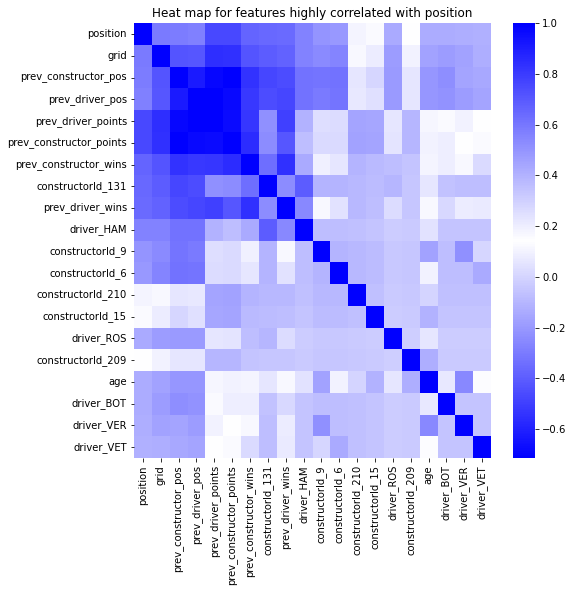

In [9]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib

# get correlation with position for all features
corr = df_results.corr()
corr = df_results[corr['position'].abs().sort_values(ascending=False).index[:20].tolist()].corr()
# cmap credit to: https://stackoverflow.com/questions/74085318/seaborn-colorbar-same-color-for-equal-absolute-values
cmap = LinearSegmentedColormap.from_list('', ['blue', 'white', 'blue'])
sns.heatmap(corr, cmap=cmap)
plt.title('Heat map for features highly correlated with position')
plt.gcf().set_size_inches(8, 8)

plt.show()

This scatter plot displays the relationship between grid position and race position for the US Grand Prix, illustrating how starting positions might impact the outcomes of the race.

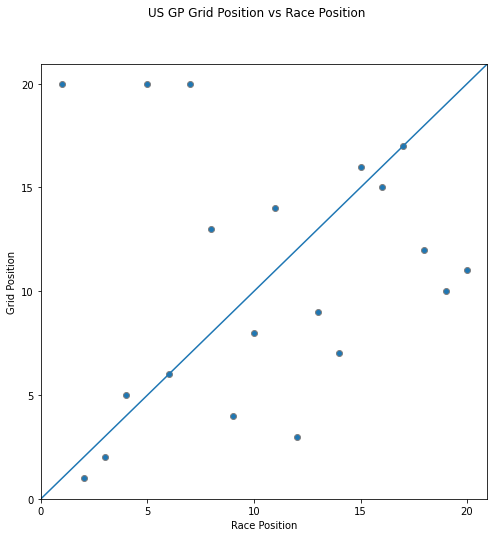

In [10]:
df_us = df_results.loc[df_results['raceId'] == 1093]
df_results = df_results.drop(columns=['raceId'])

fig, ax = plt.subplots()
ax.scatter(df_us['grid'], df_us['position'],
        edgecolor='grey')

# draw vertical lines behind the bars
ax.set_axisbelow(True)

ax.set_xlabel('Race Position')
ax.set_ylabel('Grid Position')
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.set_xticks(np.arange(0, 21, step=5))
ax.set_yticks(np.arange(0, 21, step=5))

plt.suptitle("US GP Grid Position vs Race Position")

plt.gcf().set_size_inches(8, 8)
plt.show()

## Methods:

Random Forest Regressor: As stated earlier in our introduction we believe the RFR is a good fit for this project because of its ability to handle large and complex data since our data frames had a lot of data, and they were complex. It also has the ability to model non-linear relationships, and in the complex world of Formula 1 with so many variables and factors not all of the relationships will be linear. Finally, an RFR is resistant to over-fitting and is robust. 

Linear Regression: Although the ending position or in this case, total points of a driver at the end of a race, is in its nature difficult to predict it is clear that it would be unwise to fully depend on a linear regression model to precisely determine the estimated amount of total points a driver will get in a given race. Nevertheless, a linear regression model can affirm the predictions from the Lasso Regression model and provide more insight into the relationship between variables and total points.

Decision Tree: A decision tree as a supervised machine learning algorithm is well suited for this task because similarily to the RFR it can model non-linear data. It is also efficient and robust to noisy data which is important considering how much data we have. Another critical part of a decision tree is how easy it is to read. This means our results can be easily interpreted by others even if they do not have a data science background. 

## Results:

### Linear Regression

In [11]:
def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

def show_fit(x, y, slope, intercept):
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='y_true')
    
    # compute linear predictions 
    # x is a numpy array so each element gets mulitplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='y_pred (regression)')
    
    # for each data point plot the error
    for idx, (x_i, y_i) in enumerate(zip(x, y)):
        # compute predicted position
        y_pred_i = slope * x_i + intercept
    
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    
    # compute mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    
    # add title which shows model and MSE
    plt.suptitle(f'y_hat = {slope:.2f} * x + {intercept:.2f}, MSE = {mse:.3f}')
    plt.gcf().set_size_inches(10, 5)

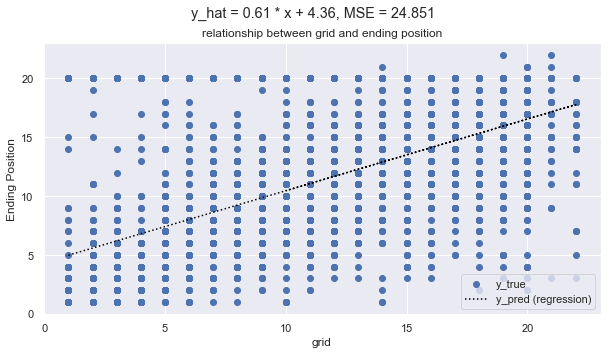

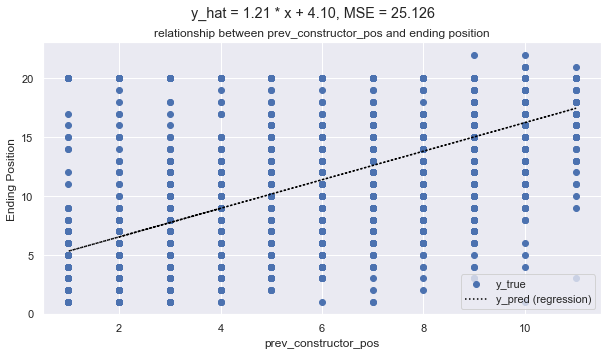

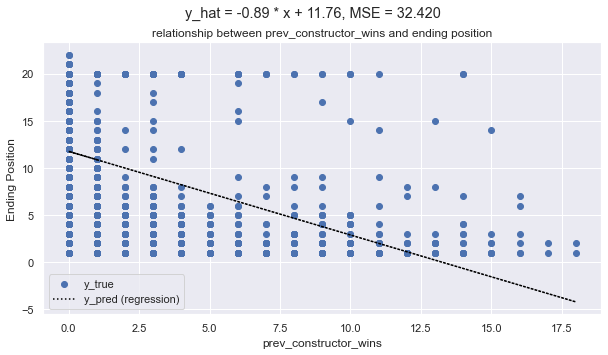

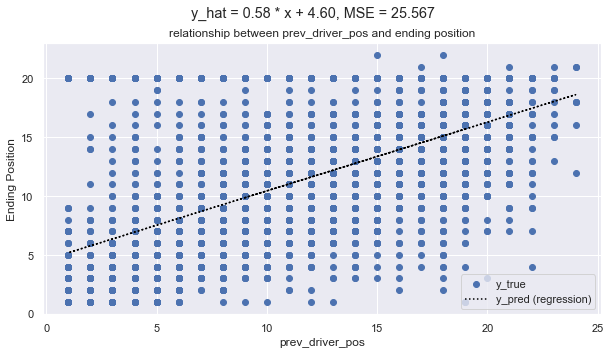

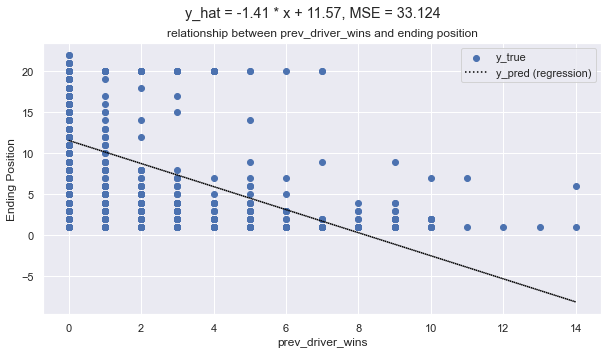

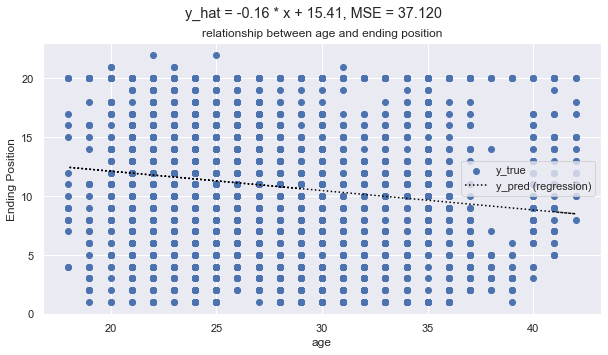

In [12]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# initialize empty table of regression stats
df_regress = pd.DataFrame()

# initialize feature lists that we are going to analyze
x_feat_list = ['grid', 'prev_constructor_pos', 'prev_constructor_wins', 'prev_driver_pos', 'prev_driver_wins', 
'age']
y_feat = 'position'

# initialize regression object
reg = LinearRegression()
y = df_results[y_feat].values

sns.set()

for feature in x_feat_list:
    x = df_results.loc[:, feature].values.reshape(-1, 1)
    
    # fit regression
    reg.fit(x, y)
    
    # observe regression
    m = reg.coef_[0]
    b = reg.intercept_
    show_fit(x, y, slope=m, intercept=b)
    plt.xlabel(feature)
    plt.ylabel('Ending Position')
    plt.title(f'relationship between {feature} and ending position')
    # make predictions given model
    y_pred = reg.predict(x)
    
    # store regression stats
    df_regress.loc[feature, 'r2'] = r2_score(y_true=y, y_pred=y_pred)
    df_regress.loc[feature, 'mse'] = get_mse(y_pred, y)
    df_regress.loc[feature, 'slope'] = reg.coef_[0]
    df_regress.loc[feature, 'intercept'] = reg.intercept_

In [13]:
df_regress

,r2,mse,slope,intercept
grid,0.343358,24.850860,0.609335,4.359232
prev_constructor_pos,0.336099,25.125596,1.213887,4.096615
prev_constructor_wins,0.143354,32.420105,-0.887275,11.760938
prev_driver_pos,0.324426,25.567362,0.584006,4.601401
prev_driver_wins,0.124751,33.124146,-1.406390,11.569715
age,0.019172,37.119829,-0.164636,15.406301


### Decision Tree Regressor

In [14]:
# create training df and test df
df_train = df_results.loc[df_results['year'] < 2021]
df_test = df_results.loc[df_results['year'] == 2021]

[Text(0.5, 0.875, 'grid <= 7.5\nsquared_error = 38.334\nsamples = 2655\nvalue = 10.933'),
 Text(0.25, 0.625, 'grid <= 4.5\nsquared_error = 32.398\nsamples = 914\nvalue = 6.335'),
 Text(0.125, 0.375, 'driver_HAM <= 0.5\nsquared_error = 27.812\nsamples = 521\nvalue = 4.678'),
 Text(0.0625, 0.125, 'squared_error = 29.526\nsamples = 409\nvalue = 5.22'),
 Text(0.1875, 0.125, 'squared_error = 16.551\nsamples = 112\nvalue = 2.696'),
 Text(0.375, 0.375, 'prev_constructor_points <= 339.0\nsquared_error = 30.01\nsamples = 393\nvalue = 8.532'),
 Text(0.3125, 0.125, 'squared_error = 30.225\nsamples = 359\nvalue = 8.891'),
 Text(0.4375, 0.125, 'squared_error = 11.959\nsamples = 34\nvalue = 4.735'),
 Text(0.75, 0.625, 'prev_driver_pos <= 14.5\nsquared_error = 24.523\nsamples = 1741\nvalue = 13.347'),
 Text(0.625, 0.375, 'prev_constructor_pos <= 4.5\nsquared_error = 27.138\nsamples = 948\nvalue = 11.768'),
 Text(0.5625, 0.125, 'squared_error = 30.862\nsamples = 300\nvalue = 10.03'),
 Text(0.6875, 0.1

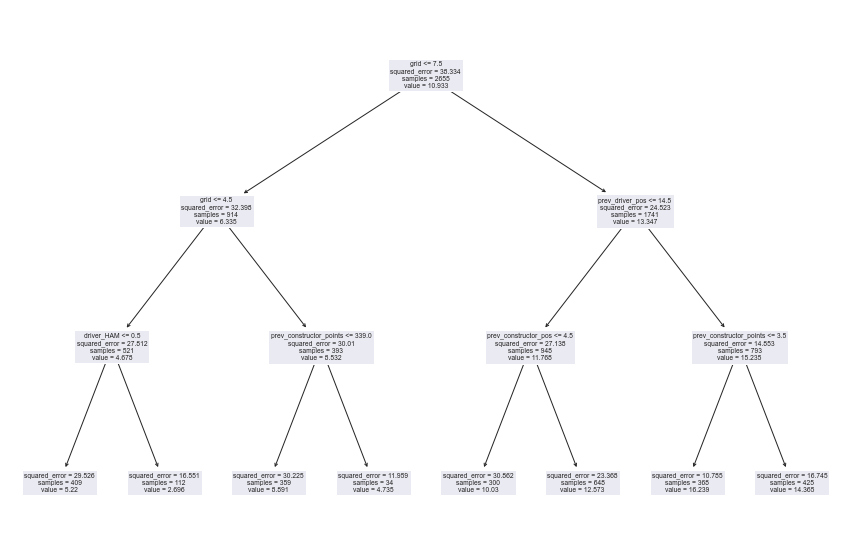

In [15]:
from sklearn import tree
import matplotlib.pyplot as plt

max_depth = 3

# classify x & y features
x_feat_list = df_train.columns.drop(['position'])
y_feat = 'position'

# extract values
x = df_train.loc[:, x_feat_list].values
y = df_train.loc[:, y_feat].values

# build tree regressor
dec_tree_reg = tree.DecisionTreeRegressor(max_depth=max_depth)

# fit data
dec_tree_reg = dec_tree_reg.fit(x, y)

# initialize empty figure
plt.figure()
plt.gcf().set_size_inches(15, 10)

# plot decision tree
tree.plot_tree(dec_tree_reg,
              feature_names=x_feat_list,
              class_names="")

In [16]:
from sklearn.metrics import mean_squared_error

# predict and get mse
x_test = df_test.loc[:, x_feat_list].values
y_test = df_test['position']

y_test_pred = dec_tree_reg.predict(x_test)
dt_result = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
print('Testing Result:')
print(f'mean_squared_error: {dt_result}')

Testing Result:
mean_squared_error: 21.990935834806997


### Random Forest Regressor 

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

n_splits = 10

x_feat_list = df_results.columns.drop(['position'])

y_feat = 'position'

# extract values
x_reg = df_train.loc[:, x_feat_list].values
y_reg = df_train.loc[:, y_feat].values

# initialize kfold object
kfold = KFold(n_splits=n_splits, shuffle=True)

# build random forest regressor
rf_reg = RandomForestRegressor()

# initialize an array of same shape and type as y
y_pred = np.empty_like(y_reg)

for train_idx, test_idx in kfold.split(x_reg, y_reg):
    # split into train and test sets
    x_train = x_reg[train_idx, :]
    y_train = y_reg[train_idx]
    x_test = x_reg[test_idx, :]
    
    # fit classifier (on training set)
    rf_reg.fit(x_train, y_train)
    
    # predict (on testing set)
    y_pred[test_idx] = rf_reg.predict(x_test)


In [18]:
print('Testing Result:')
print(f'mean_squared_error : {mean_squared_error(y_true=y_reg, y_pred=y_pred)}')

Testing Result:
mean_squared_error : 25.661393596986816


In [19]:
# credit: Prof. Matt Higger
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[-limit:]
        feat_import = feat_import[-limit:]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across all Decision Trees)')

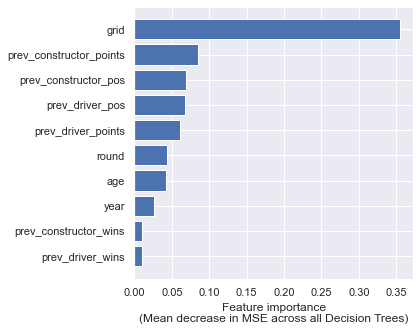

In [20]:
plot_feat_import(x_feat_list, rf_reg.feature_importances_, limit=10)

In [21]:
x_test = df_test.loc[:, x_feat_list].values
y_test = df_test['position']

y_test_pred = rf_reg.predict(x_test)
rfr_result = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
print('Testing Result')
print(f'mean_squared_error: {rfr_result}')

Testing Result
mean_squared_error: 21.865721052631578


### Benchmark (predicting only based on grid position)

In [22]:
# prediction: finishing position equals grid position
x_feat_list = ['grid']
y_feat = 'position'
y_pred = df_test.loc[:, x_feat_list].values
y_true = df_test.loc[:, y_feat].values
benchmark_result = mean_squared_error(y_true=y_true, y_pred=y_pred)
print('Testing Result')
print(f'mean_squared_error: {benchmark_result}')

Testing Result
mean_squared_error: 26.09090909090909


### Performance Comparison:

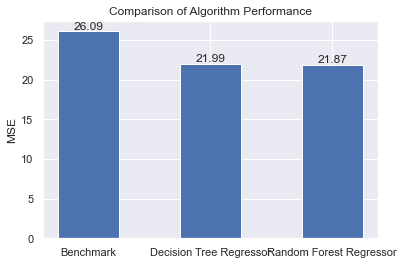

In [23]:
methods = ['Benchmark', 'Decision Tree Regressor', 'Random Forest Regressor']
performance = [benchmark_result, dt_result, rfr_result]

# create bar plot
fig, ax = plt.subplots()
bar_width = 0.5
bar_positions = np.arange(3)

bars = ax.bar(bar_positions, performance, bar_width, align='center')

# add labels above each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

ax.set_xticks(bar_positions)
ax.set_xticklabels(methods)
ax.set_ylabel('MSE')
ax.set_title('Comparison of Algorithm Performance')

plt.show()

## Discussion:

While our analysis yielded some expected results, there were also a few surprises that caught our attention. One such instance was the feature importance graph, which revealed that the "quality" of the car, the "quality" of the driver's skill level, and the starting grid position were the top-ranked factors, as anticipated. Our model in the analysis also recorded a 16.17% decrease in MSE compared to the benchmark when predicting finishing positions. However, it was rather unexpected to see Lewis Hamilton emerge as a significant feature importance in his own right, which came as a bit of a shock to us because we knew that he was a dominant driver, but not THAT dominant. Another result that our analysis yielded was older Formula 1 drivers tend to score more points than younger ones, which is a bit counterintuitive because we expected younger drivers to have better reflexes hence a better racer, but it appears that experience is more important in Formula 1. Our results should not be taken at face value, because our dataset is biased towards Mercedes since the years that we drew our data from were dominated by them. Also, this data is only on hybrid-era cars, so if there are new regulation changes our observations might not remain true.   

Though there are no real takeaways to be taken from, our analysis paints a decent, albeit somewhat obvious, insight into what impacts the ending position of f1 drivers for a given race. With our model, the factors that play into f1 racing can help old fanatics and new fans alike in seeing the importance of a variety of factors and even how the presence of a singular driver/constructor can sway driver placements. However, that does not go without some ethical concerns that come with predicting f1 placements in a race, namely encouraging gambling habits. As with anything competitive, there is an incentive to cheat and gambling is no exception, and building a tool that facilitates both gambling and cheating is inherently a significant ethical concern. While our random forest regressor does a good job in naming top 10 drivers for a race, luckily, and unfortunately, our model's results are unsurprising and would not be extremely useful in providing an individual an upper-hand advantage in the gambling scene. Therefore, though there is an ethical issue present in our project, it is nowhere near a pressing issue that would bring harm to any individual.